In [49]:
import glob
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from skimage.measure import find_contours
from scipy.spatial.distance import dice
from skimage.transform import rescale
from scipy.io import loadmat

from scipy import ndimage as ndi
from skimage import io as skio
from skimage.filters import threshold_otsu
import skimage.morphology as morpho  
from skimage.transform import rescale
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import img_as_float
from skimage.segmentation import chan_vese
from skimage.segmentation import checkerboard_level_set
from skimage.segmentation import circle_level_set


--- French ---
L'objectif de ce TP est de tester différentes méthodes de segmentation vues dans les cours sur des images médicales de différents types : scanner à rayons X (CT) pour la segmentation des reins, IRM du cerveau pour la segmentation du corps calleux, séquences temporelles d'images IRM pour la segmentation du coeur (ventricule gauche par exemple), images dermoscopiques de lésions de la peau.
Pour chaque méthode, il faudra la tester et l'évaluer sur le plus possible d'images.

--- English ----
The goal of this practical session is to test the different segmentation techniques you have seen so far during the lectures on several medical images. You will have at your disposal: CT renal scan, brain MRI, heart MRI and dermoscopic images.  Each technique should be tested on - as many as possible - different medical images.



In [50]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd

  gdd.download_file_from_google_drive(file_id='1E-F5x83qaPRUrcdusfyOSgiZWf0pLDFl',
                                      dest_path='./abdominalCT.zip',
                                      unzip=True)

  gdd.download_file_from_google_drive(file_id='1UTSW2nGWV8SBE_ILZQkM-jQvnfoQKDlm',
                                      dest_path='./brainMRI.zip',
                                      unzip=True)  

  gdd.download_file_from_google_drive(file_id='1BZtShVk7LVG032GOlcLs0K4Eaj6gnBed',
                                      dest_path='./MRIheart.zip',
                                      unzip=True)    

  gdd.download_file_from_google_drive(file_id='1BoU4S9xFgKaCtquU03kZQbH3Yv42oU_-',
                                      dest_path='./skinlesion.zip',
                                      unzip=True)   
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
Working_directory="./"                              

## Abdominal CT 

You have at your disposal 6 abdominal CT scans of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor.

In [51]:
abdominalCT_path = Working_directory + 'abdominalCT'
!ls './abdominalCT'

listImagesabdCT=glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT),  'abdomical CT images')
print(listImagesabdCT)

CTs1-seg.tiff  CTs2.tiff      CTs4-seg.tiff  CTs5.tiff
CTs1.tiff      CTs3-seg.tiff  CTs4.tiff      CTs6-seg.tiff
CTs2-seg.tiff  CTs3.tiff      CTs5-seg.tiff  CTs6.tiff
There are 6 abdomical CT images
['./abdominalCT/CTs1-seg.tiff', './abdominalCT/CTs6-seg.tiff', './abdominalCT/CTs3-seg.tiff', './abdominalCT/CTs4-seg.tiff', './abdominalCT/CTs2-seg.tiff', './abdominalCT/CTs5-seg.tiff']


Reading image  ./abdominalCT/CTs1.tiff
[  0 127 255]


Text(0.5, 1.0, 'Image with mask tumor')

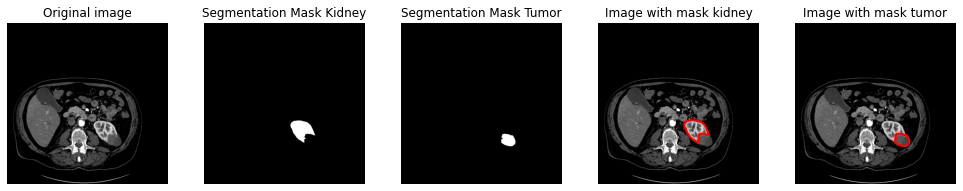

In [52]:
# Choose a figure and plot it with the ground truth segmentation
indexIm=0 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm]
im_Seg = imread(filename_Segmentation)
filename = filename_Segmentation[:-9] + '.tiff'
imG = imread(filename) 

print('Reading image ', filename)
print(np.unique(im_Seg))

if imG.shape != im_Seg.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg, we may have two values: 127 is for kidney and 255 for renal tumor
maskKidney=im_Seg==127
if np.sum(maskKidney)==0:
  print('There is no kidney')
contourMaskKidney = find_contours(maskKidney, 0.5)

maskTumor=im_Seg==255
if np.sum(maskTumor)==0:
  print('There is no tumor')
contourMaskTumor = find_contours(maskTumor, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(imG, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskKidney,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(maskTumor,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(imG, cmap='gray')
for contour in contourMaskKidney:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image with mask kidney")
grid[4].imshow(imG, cmap='gray')
for contour in contourMaskTumor:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image with mask tumor")


# Brain MRI

Here you can select medial slices of the brain of 4 different subjects. You also have manual segmentations of the corpus callosum.

In [53]:
brainMRI_path = Working_directory + 'brainMRI'
!ls './brainMRI'

listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

MRIs1.png      MRIs2.png      MRIs3.png      MRIs4.png
MRIs1-seg.png  MRIs2-seg.png  MRIs3-seg.png  MRIs4-seg.png
There are 4 brain MRI images
['./brainMRI/MRIs1-seg.png', './brainMRI/MRIs4-seg.png', './brainMRI/MRIs2-seg.png', './brainMRI/MRIs3-seg.png']


./brainMRI/MRIs3-seg.png
Reading image  ./brainMRI/MRIs3.png


Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

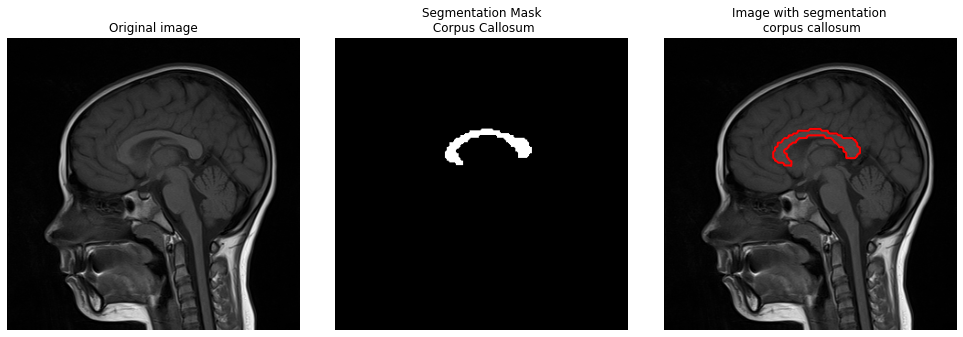

In [54]:
# Choose a figure and plot it with the ground truth segmentation
indexIm=3 # between 0 and 3

# Brain MRI
filename_Segmentation = listImagesbrainMRI[indexIm]
print(filename_Segmentation)
im_Seg = imread(filename_Segmentation)
filename = filename_Segmentation[:-8] + '.png'
imG = imread(filename) 

print('Reading image ', filename)

if imG.shape != im_Seg.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC=im_Seg==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(imG, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum")
grid[2].imshow(imG, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")


# Skin lesions

In this section, you can try to segment skin lesions (both nevi and melanoma).  You also have manual segmentations. Be careful to the hair...

In [55]:
skinlesion_path = Working_directory + 'skinlesion'
!ls './skinlesion'

listImages=glob.glob(skinlesion_path + '/*.jpg')
N=len(listImages)
print('There are {} skin lesion images'.format(N))
print(listImages)


IM_000180.jpg		    IM_000833_Segmentation.png
IM_000180_Segmentation.png  ISIC_0000001.jpg
IM_000215.jpg		    ISIC_0000001_Segmentation.png
IM_000215_Segmentation.png  ISIC_0000019.jpg
IM_000407.jpg		    ISIC_0000019_Segmentation.png
IM_000407_Segmentation.png  ISIC_0000042.jpg
IM_000445.jpg		    ISIC_0000042_Segmentation.png
IM_000445_Segmentation.png  ISIC_0000046.jpg
IM_000510.jpg		    ISIC_0000046_Segmentation.png
IM_000510_Segmentation.png  ISIC_0000095.jpg
IM_000613.jpg		    ISIC_0000095_Segmentation.png
IM_000613_Segmentation.png  ISIC_0000146.jpg
IM_000833.jpg		    ISIC_0000146_Segmentation.png
There are 13 skin lesion images
['./skinlesion/IM_000445.jpg', './skinlesion/IM_000215.jpg', './skinlesion/ISIC_0000019.jpg', './skinlesion/IM_000407.jpg', './skinlesion/IM_000180.jpg', './skinlesion/IM_000833.jpg', './skinlesion/IM_000510.jpg', './skinlesion/ISIC_0000001.jpg', './skinlesion/IM_000613.jpg', './skinlesion/ISIC_0000042.jpg', './skinlesion/ISIC_0000095.jpg', './skinlesion/I

Text(0.5, 1.0, 'Image with mask')

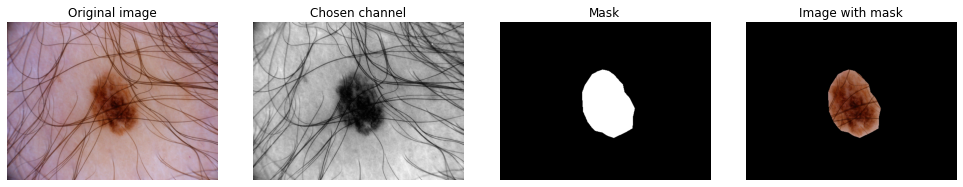

In [56]:
# Let's load the images, rescale them so that the computations are faster and plot them
# Choose the index of the skin lesion image you want to analyze
indexIm=10
####

filename = listImages[indexIm]
im = imread(filename)
im=im[2:-2,2:-2,:] # remove border (it contains artifacts)
im = np.uint8(rescale(im, 0.25,multichannel=True, anti_aliasing=True)*255)

# To simplify things, let's choose only one channel (gray image)
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2
##
imG = im[:,:,channel] 

filename_Segmentation = filename[:-4] + '_Segmentation.png'
im_Seg = imread(filename_Segmentation) # Value 0 or 255
im_Seg=im_Seg[2:-2,2:-2] # remove border (it contains artifacts)
im_Seg = rescale(im_Seg, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
maskSL = im_Seg==255 
im_Seg_expand = np.expand_dims(maskSL, axis=2)


fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 4),
                axes_pad = 0.5)
grid[0].imshow(im)
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(imG,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Chosen channel")
grid[2].imshow(maskSL,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Mask")
grid[3].imshow(im_Seg_expand*im)
grid[3].axis('off')
grid[3].set_title("Image with mask")

# MRI heart

The last section is about MRI sequences of the heart. Your goal is to segment the left ventricule. Be careful, the segmentation is not a mask but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline).


In [57]:
MRIheart_path = Working_directory + 'MRIheart/'
!ls './MRIheart'

dataMRIheart.mat  segMRIheart.mat


In [58]:
data=loadmat(MRIheart_path + 'dataMRIheart.mat')
data=data['data']
seg=loadmat(MRIheart_path + 'segMRIheart.mat')
seg=seg['seg']

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3], 
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not have the left ventricle and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not have the left ventricle and the manual segmentation is not simply empty but it contains the value: [[-99999]]


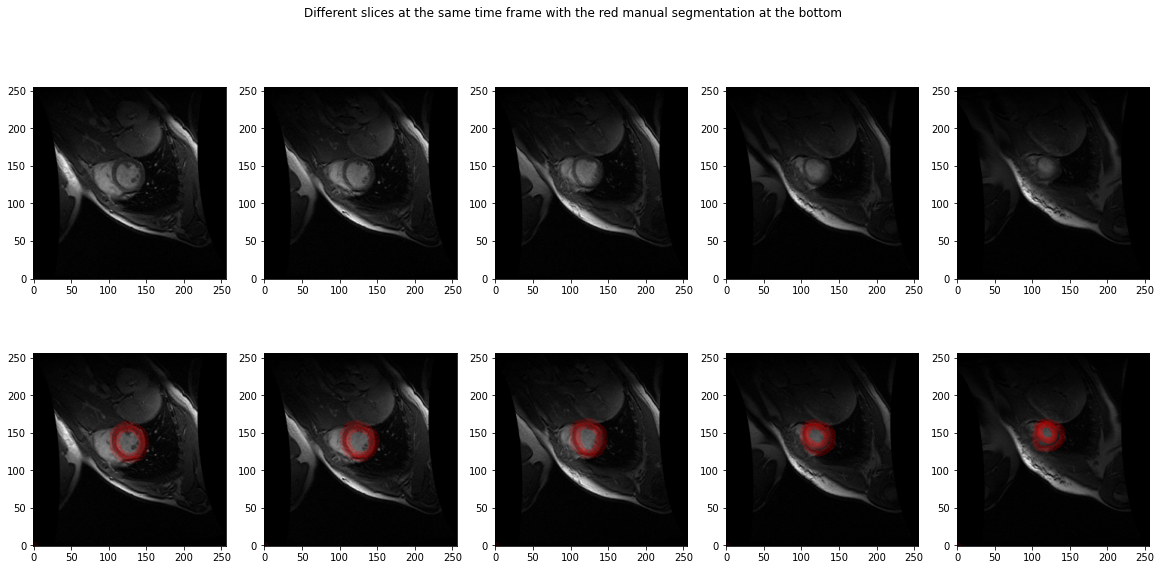

In [59]:
plt.figure(figsize=(20, 9))
plt.suptitle('Different slices at the same time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1) 

## Useful functions

In [60]:
def strel(forme,taille,angle=45):
    """renvoie un element structurant de forme  
     'diamond'  boule de la norme 1 fermee de rayon taille
     'disk'     boule de la norme 2 fermee de rayon taille
     'square'   carre de cote taille (il vaut mieux utiliser taille=impair)
     'line'     segment de langueur taille et d'orientation angle (entre 0 et 180 en degres)
      (Cette fonction n'est pas standard dans python)
    """

    if forme == 'diamond':
        return morpho.selem.diamond(taille)
    if forme == 'disk':
        return morpho.selem.disk(taille)
    if forme == 'square':
        return morpho.selem.square(taille)
    if forme == 'line':
        angle=int(-np.round(angle))
        angle=angle%180
        angle=np.float32(angle)/180.0*np.pi
        x=int(np.round(np.cos(angle)*taille))
        y=int(np.round(np.sin(angle)*taille))
        if x**2+y**2 == 0:
            if abs(np.cos(angle))>abs(np.sin(angle)):
                x=int(np.sign(np.cos(angle)))
                y=0
            else:
                y=int(np.sign(np.sin(angle)))
                x=0
        rr,cc=morpho.selem.draw.line(0,0,y,x)
        rr=rr-rr.min()
        cc=cc-cc.min()
        img=np.zeros((rr.max()+1,cc.max()+1) )
        img[rr,cc]=1
        return img
    raise RuntimeError('Erreur dans fonction strel: forme incomprise')



To quantitavely compare two segmentations, we can use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient). Remember that you should also visually compare your segmentation and the reference one, when available. 

In [61]:
# Evaluation quantitative par indice de Dice (vous pouvez aussi utiliser la fonctionne dice de scipy)
def Dice(segm,segm_ref):
    if segm.shape != segm_ref.shape:
        raise ValueError("Les deux images doivent avoir la meme taille.")
    segm = np.asarray(segm).astype(np.bool)
    segm_ref = np.asarray(segm_ref).astype(np.bool)
    intersection = np.logical_and(segm, segm_ref)
    dice = 2.0 * intersection.sum() / (segm.sum()+segm_ref.sum())
    return dice

# Comparaison visuelle (segm peut être un masque de segmentation ou son contour)
# vous pouvez aussi utiliser la fonctionen find_contours
def ComparVisu(image,segm):
    return np.maximum(image,segm)
def Contour(segm):
    se=morpho.selem.disk(1)
    contour=morpho.dilation(segm,se)-segm
    # ou dilatation - erosion pour avoir un contour de 2 pixels d'épaisseur (plus visible)
    return contour

## 1. Threshold segmentation
- First, compare the histograms of the images of the same modality. Do the histograms have the same range of values across modalities ? Could you use the same threshold (manually found) across modalities to correctly retrieve the segmentation ? Comment the results.


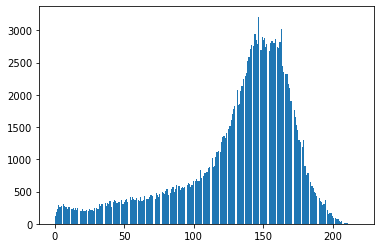

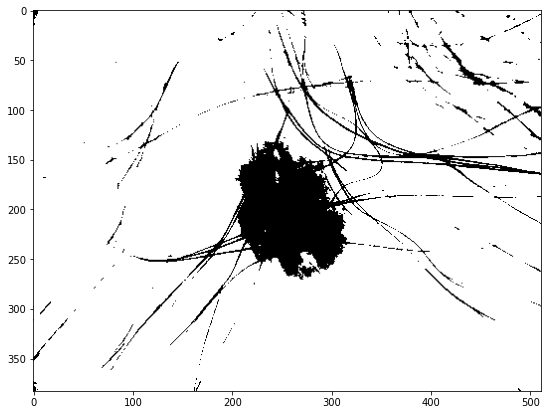

In [62]:
# Histogram
im=imG
ax = plt.hist(im.ravel(), bins = 256)
plt.show()

# manual thresholding
thresh = 60
binary = (im > thresh) *255
fig = plt.figure(figsize=(17, 7))
plt.imshow(binary, cmap="gray", vmin=0, vmax=255)


###Otsu's algorithm

Otsu's method looks for a threshold to split a gray-level image into two separate regions, based on their grey-level values. Since the maximum number of grey-levels is finite (and small, 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the intra-class intensity variance, defined as a weighted sum of the variances of the two regions :

$argmin_{\tau}  \omega_0(\tau)\sigma_0^2(\tau) + \omega_1(\tau)\sigma_1^2(t)$

where

- $\sigma_0^2(\tau)$ and $\sigma_1^2(\tau)$ are the intensity variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are the weights of the first and second regions 

Given the histogram of the image with $L$ bins where each bin $i$ has $p(i)$ pixels, we define the weights $\omega_0(\tau)$ and $\omega_1(\tau)$ as:

- $\omega_0(\tau) = \sum_{i=0}^{\tau -1} p(i)$
- $\omega_1(\tau) = \sum_{i = \tau}^{L-1} p(i)$


Use the function ``threshold_otsu`` across different modalities. Comment the results. Does the algorithm find the same threshold as the one you previously found manually?

Otsu threshold is  107


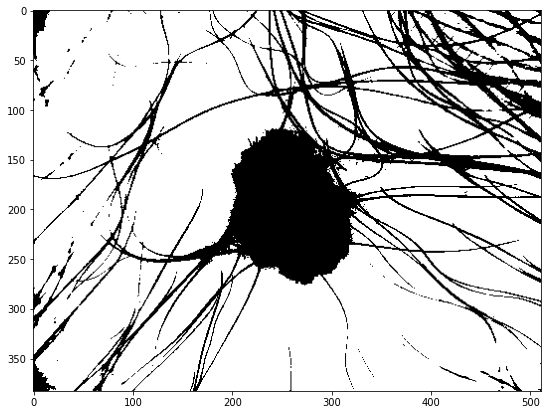

In [63]:
# seuillage d'Otsu

im=imG
threshOtsu = threshold_otsu(im)
print('Otsu threshold is ', threshOtsu)
binaryOtsu = (im > threshOtsu) *255
fig = plt.figure(figsize=(17, 7))
plt.imshow(binaryOtsu, cmap="gray", vmin=0, vmax=255)

### K-means

Now, let's try to use K-means to directly segment the image. We will use the scikit-learn implementation.

Try to change the number of clusters, can you correctly segment all modalities ? Would you choose the same number of clusters for all modalities ? Once found the clusters, how would you choose the one to use as segmentation mask ?
Comment the results.

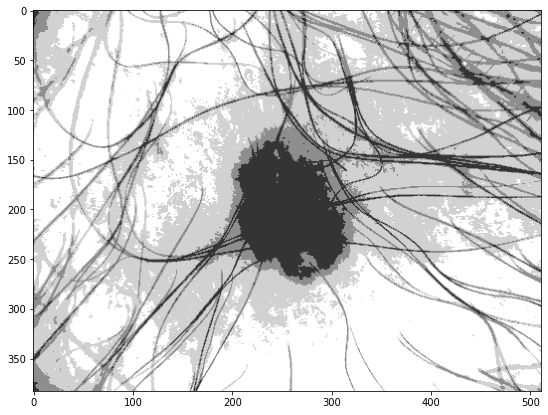

In [64]:
#k-means
from sklearn.cluster import KMeans

im=imG
Ncluster=4

x, y = im.shape
imFloat = np.array(im, dtype=np.float64) / 255 # transform into float for computational reason
kmeans = KMeans(n_clusters=Ncluster, n_jobs=-1) # use K-means algorithm 
kmeans.fit(imFloat.reshape(x*y,1)) # fit to the data reshapds as a 1D vector

cluster_centers = kmeans.cluster_centers_ # estimated centers
cluster_labels = kmeans.labels_ # estimated labels for each pixel

kmeansSeg = cluster_centers[cluster_labels].reshape(x, y) # reshaped as the original image

fig = plt.figure(figsize=(17, 7))
plt.imshow(kmeansSeg, cmap="gray", vmin=0, vmax=np.max(kmeansSeg))

## 2. Region growing

The region growing algorithm is quite simple : we start with a small region, and add pixels progressively to the region, according to a criterion. We choose the following criterion :

- A pixel $p$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, we can create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.
The initialization can be done using a single point or using one of the previous techniques which can also be improved using pre- or post processing techniques. Would you use the same strategy (ie algorithm) for all medical images ? Propose a strategy for each medical image.

Here you can find an example of algorithm. Please modify it accordingly to each modality.


In [65]:
from scipy.ndimage.morphology import distance_transform_edt

def initialize_segmentation(seed_pt,img_shape):
    seg_init = np.zeros(img_shape).astype(float)
    seg_init[ seed_pt[0], seed_pt[1]] = 1
    dist = distance_transform_edt(np.abs(1-seg_init))

    # initialise the seeded region with a certain radius
    size_radius = 5
    seg_init = dist < size_radius
    return seg_init


Text(0.5, 1.0, 'Region growing segmentation')

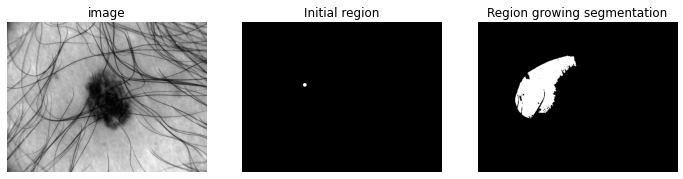

In [66]:
def segmentation_region_growing(img,seed_pt,tau):

    # define the neighbourhood (for instance 4-connected pixels)
    se=morpho.selem.diamond(1)

    seg_init = initialize_segmentation(seed_pt,img.shape)
    seg_n_plus_1 = seg_init
    seg_n = np.zeros(seg_n_plus_1.shape)

    # loop while the region can still keep growing
    while( np.abs(seg_n_plus_1 != seg_n).sum() != 0):
        seg_n = seg_n_plus_1
        seg_n_plus_1 = morpho.dilation(seg_n, se).astype(seg_n.dtype)
        # calculate average value
        avg = np.sum( img[seg_n>0] ) / ( float(seg_n.sum()))
        seg_n_plus_1 = np.logical_and( seg_n_plus_1 , np.abs( img-avg ) < tau)
        # do not lose previous points of the segmentation
        seg_n_plus_1 = np.logical_or( seg_n_plus_1 , seg_n)

    return seg_n,seg_init

im=imG
seed_pt = np.asarray([160,160])  # initialization with only one point - Try to modify the code to initialize with one region obtained previously
tau = 20
img_out_region_growing,seg_init = segmentation_region_growing(im,seed_pt,tau)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(im,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(seg_init,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Initial region")
grid[2].imshow(img_out_region_growing,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Region growing segmentation")


## 3. Watershed segmentation

The initialization can be done using a single point or using one of the previous techniques which can also be improved using pre- or post processing techniques. Would you use the same strategy (ie algorithm) for all medical images ? Propose a strategy for each medical image.

Here you can find an example of algorithm. Please modify it accordingly to each modality.

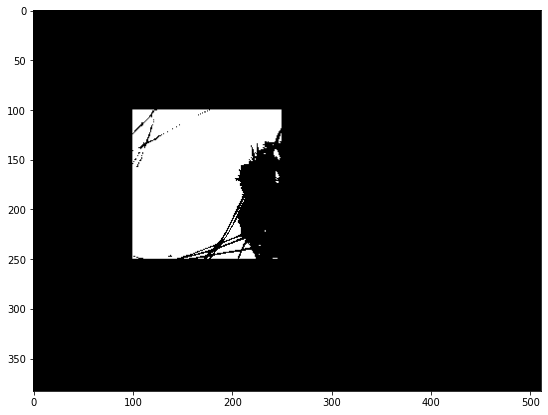

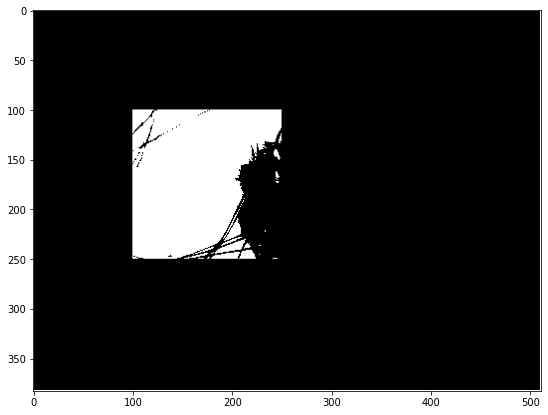

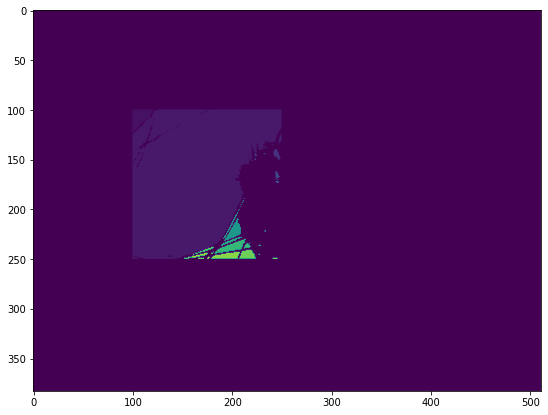

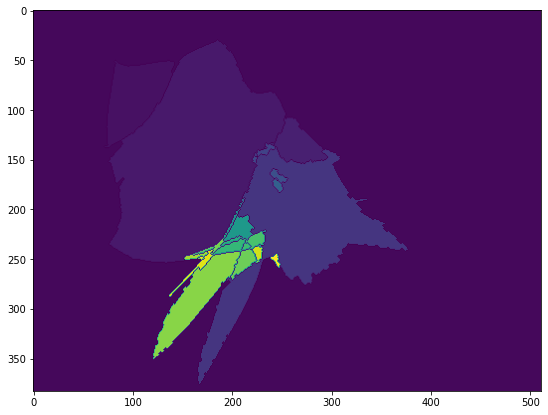

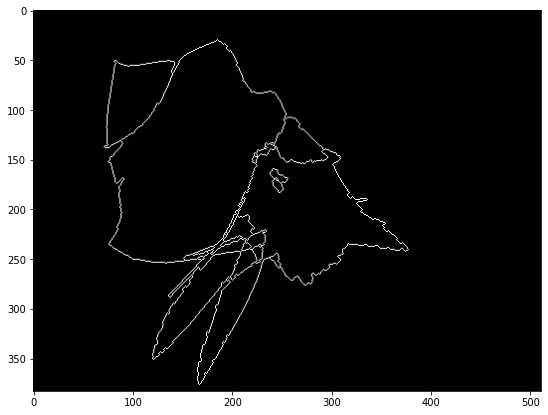

In [67]:
im=imG
#gradient morphologique de l'image initiale
se=morpho.selem.disk(1)
grad=morpho.dilation(im,se)-morpho.erosion(im,se)
fig = plt.figure(figsize=(17, 7))
plt.imshow(grad, cmap="gray")

# Exemple d'initialization (qui doit être modifié...)
temp=np.zeros((binary.shape[0],binary.shape[1]),dtype=np.uint8)
for i in range(100,250):
    for j in range(100,250):
        temp[i,j]=255
init=np.minimum(binary,temp)

plt.imshow(init, cmap="gray", vmin=0, vmax=255)


#ajout d'un marqueur sur le bord de l'image
for i in range(init.shape[0]):
    init[i,0]=255
    init[i,init.shape[1]-1]=255
for j in range(init.shape[1]):
    init[0,j]=255
    init[init.shape[0]-1,j]=255
fig = plt.figure(figsize=(17, 7))
plt.imshow(init, cmap="gray", vmin=0, vmax=255)

markers = ndi.label(init)[0]
fig = plt.figure(figsize=(17, 7))
plt.imshow(markers)

labels = morpho.watershed(grad, markers,watershed_line=True)
fig = plt.figure(figsize=(17, 7))
plt.imshow(labels)

# visualiation du resultat
segm=labels.copy()
for i in range(segm.shape[0]):
    for j in range(segm.shape[1]):
        if segm[i,j] == 0: 
            segm[i,j]=255
        else:
            segm[i,j]=0
fig = plt.figure(figsize=(17, 7))
plt.imshow(segm, cmap="gray", vmin=0, vmax=255)

6. Segmentation d'une séquence - Sur les images d'IRM cardiaque, proposer une méthode de segmentation qui utilise le résultat à un instant pour initialiser la segmentation à l'instant suivant (par exemple sur la coupe z=2 ou z=3). Illustrer et discuter. Est-ce pertinent d'utiliser la même approche pour guider la segmentation d'une coupe par celle de la coupe précédente ?